# Coursera Capstone Project 

This is a Descriptive Analysis of the spread of Covid19 in New York City, NY, USA.

## Data Acquisition

#### Installing BeautifulSoup4 and importing needed initial packages 

In [1]:
#!pip install beautifulsoup4
#!pip install lxml
#!pip install requests

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv 

print('Initial packages installed')

Initial packages installed


### Scraping Covid19 statistics from NYC Health's Github account 

The data is saved in a .csv file and is updated regularly. It contains a list of NYC zipcodes with:
 <ul>
  <li>The number of tests with a positive result</li>
  <li>The total number of tests taken within the zip code</li>
  <li>The positive tests as a percentage of the total tests</li>
</ul> 

In [2]:
nyc_raw = requests.get('https://github.com/nychealth/coronavirus-data/blob/master/tests-by-zcta.csv').text
nyc_soup = BeautifulSoup(nyc_raw, 'lxml')

#### Scraping the page and extracting the .csv table and its content 

The rows and data were copied and stored in a dataframe called "df_covid19"

In [3]:
soup_content = nyc_soup.find('div', class_='application-main')
nyc_table = soup_content.find('table', class_='js-csv-data csv-data js-file-line-container')
table = nyc_table.find_all('tbody')
#table

rows = table[0].find_all('tr')
#rows

In [4]:
zipcodes = []
positive_tests = []
total_tests = []
percentage_total = []

for row in rows:    
    columns = row.find_all('td')
    
    zipcode = columns[1].text
    positive_test = columns[2].text
    total_test = columns[3].text
    percentage = columns[4].text
    
    zipcodes.append(zipcode)
    positive_tests.append(positive_test)
    total_tests.append(total_test)
    percentage_total.append(percentage)
    

    

In [5]:
df_covid19 = pd.DataFrame(list(zip(zipcodes, positive_tests, total_tests, percentage_total)), \
                  columns =['Zip Code', 'Positive Tests','Total Tests', 'Percentage of Total']) 

df_covid19.head()

,Zip Code,Positive Tests,Total Tests,Percentage of Total
0,NA,1845,2073,89
1,10001,266,600,44.33
2,10002,729,1419,51.37
3,10003,355,857,41.42
4,10004,26,66,39.39


In [6]:
# The first row was dropped for analysis purposes 

df_covid19.drop([0], axis = 0, inplace = True)
df_covid19.reset_index(drop=True).head(10)

,Zip Code,Positive Tests,Total Tests,Percentage of Total
0,10001,266,600,44.33
1,10002,729,1419,51.37
2,10003,355,857,41.42
3,10004,26,66,39.39
4,10005,44,140,31.43
5,10006,15,58,25.86
6,10007,42,142,29.58
7,10009,530,1230,43.09
8,10010,203,591,34.35
9,10011,403,892,45.18


### Scraping NYC's demographic statistics from city-data.com

This page contains a list of zipcode with its:
 <ul>
  <li>Population Density</li>
  <li>Median Income</li>
</ul> 

Some zip codes have missing data which will be addressed below.

In [7]:
nyc_stat_raw = requests.get('http://www.city-data.com/zipmaps/New-York-New-York.html').text
stat_soup = BeautifulSoup(nyc_stat_raw, 'lxml') 

In [8]:
stat_soup_content = stat_soup.find('div',{"id": "body"}, class_='container-fluid')

#### Gets the list of available zipcodes on the page

In [9]:
avail_zipcodes_raw = stat_soup.find('div', class_='zip-codes')
zip_rows = avail_zipcodes_raw.find_all('a')
#zip_rows

In [10]:
zip_rows_clean = []
for row in zip_rows:
    zip_rows_clean.append(row.text)
    

#### The following rows are either hidden or do not contain data, and they will be removed from the list of zip codes

In [11]:
#prints the index of the zip codes to be removed

print(zip_rows_clean.index('10020'))
print(zip_rows_clean.index('10065'))
print(zip_rows_clean.index('10075'))
print(zip_rows_clean.index('10103'))
print(zip_rows_clean.index('10110'))
print(zip_rows_clean.index('10111'))
print(zip_rows_clean.index('10112'))
print(zip_rows_clean.index('10115'))
print(zip_rows_clean.index('10119'))
print(zip_rows_clean.index('10152'))
print(zip_rows_clean.index('10153'))
print(zip_rows_clean.index('10154'))
print(zip_rows_clean.index('10165'))
print(zip_rows_clean.index('10167'))
print(zip_rows_clean.index('10168'))
print(zip_rows_clean.index('10169'))
print(zip_rows_clean.index('10170'))
print(zip_rows_clean.index('10171'))
print(zip_rows_clean.index('10172'))
print(zip_rows_clean.index('10173'))
print(zip_rows_clean.index('10174'))
print(zip_rows_clean.index('10177'))
print(zip_rows_clean.index('10199'))
print(zip_rows_clean.index('10271'))
print(zip_rows_clean.index('10278'))
print(zip_rows_clean.index('10279'))
print(zip_rows_clean.index('10311'))
print(zip_rows_clean.index('11109'))
print(zip_rows_clean.index('11371'))

17
39
41
42
43
44
45
46
47
49
50
51
53
54
55
56
57
58
59
60
61
62
63
64
65
66
79
118
174


In [12]:
# deletes these rows from zip_rows_clean

index_list = [17,39,41,42,43,44,45,46,47,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,79,118,174]
zip_rows_clean1 = np.delete(zip_rows_clean, index_list).tolist()


#### Scraping the population density and median income data from each zip code data block

In [13]:
# Finds all data blocks

table_data = stat_soup.find_all('div', class_='zip data-block')

#### This function formats each data entry and assigns it as a float 

In [14]:
def clean_pop(element):
    element = str(element)
    element = element.replace(' ','') # removes empty space 
    element = element.replace(',','') # removes comma 
    element = float(element)          # changes data type to float 
    return element


def clean_income(element):
    element = str(element)
    element = element.replace('$','') # removes $ sign
    element = element.replace(' ','') # removes empty space
    element = element.replace(',','') # removes comma 
    element = float(element)          # changes data type to float 
    return element

#### Demographic statistics are storerd in a DataFrame called "df_stats"

In [15]:
populations = []
incomes = []

for data in table_data:
    try:
        population = data.find_all('b')[9].next_sibling
        population = clean_pop(population)
        
    
        income = data.find('b', text = 'Estimated median household income in 2016:').next_sibling
        income = clean_income(income)
    
        populations.append(population)
        incomes.append(income)
        
    except Exception as e:
        pass


In [16]:
df_stats = pd.DataFrame(list(zip(zip_rows_clean1,populations,incomes)), \
                  columns =['Zip Code', 'Population Density', 'Median Income'])

df_stats.head()

,Zip Code,Population Density,Median Income
0,10001,38085.0,88701.0
1,10002,90078.0,37071.0
2,10003,99889.0,104972.0
3,10004,5515.0,128161.0
4,10005,120158.0,135514.0


#### Performing inner join to compile Covid19 and demographic data into one DataFrame named "df_merged"

In [17]:
df_merged = pd.merge(left=df_covid19, right=df_stats, left_on='Zip Code', right_on='Zip Code')
df_merged.head()

,Zip Code,Positive Tests,Total Tests,Percentage of Total,Population Density,Median Income
0,10001,266,600,44.33,38085.0,88701.0
1,10002,729,1419,51.37,90078.0,37071.0
2,10003,355,857,41.42,99889.0,104972.0
3,10004,26,66,39.39,5515.0,128161.0
4,10005,44,140,31.43,120158.0,135514.0


#### Entries after 123 are removed due to missing/messy data

In [18]:
list1 = list(range(123,169))
df_merged.drop(list1, axis = 0, inplace = True)

### OpenCage API is used to gather the latitude, longitude, and venue data for each zip code

#### OpenCage API credentials

In [19]:
API_KEY = '5e232949c48244eb888c484b236c9534'

In [20]:
import json 

#creates list of zipcodes from df_merged 
df_zips = df_merged['Zip Code'].values

latitudes = [] #initializes empty list to append latitude data
longitudes = [] #initializes empty list to append longitude data

for zipcode in df_zips:
    location_input = str(zipcode) + " New York City, NY" # correct location input format 
    url = 'https://api.opencagedata.com/geocode/v1/json?q={}&key={}'.format(location_input, API_KEY) # correct url format
    obj = json.loads(requests.get(url).text)  # Gets the json file, stores in a dictionary
    
    results = obj['results'] # gets the 'results' key
    latitude = results[0]['geometry']['lat'] # gets the 'latitude' data 
    longitude = results[0]['geometry']['lng'] #gets the 'longitude' data
    
    latitudes.append(latitude) # Appends data to the list of latitudes
    longitudes.append(longitude) # Appends data to the list of longitudes

#### Creates columns for each zip code's latitude and longitude

In [21]:
df_merged['Latitude'] = latitudes
df_merged['Longitude'] = longitudes
df_merged.head()

,Zip Code,Positive Tests,Total Tests,Percentage of Total,Population Density,Median Income,Latitude,Longitude
0,10001,266,600,44.33,38085.0,88701.0,40.729825,-73.960752
1,10002,729,1419,51.37,90078.0,37071.0,40.722313,-73.987709
2,10003,355,857,41.42,99889.0,104972.0,40.731609,-73.988484
3,10004,26,66,39.39,5515.0,128161.0,40.700732,-74.013475
4,10005,44,140,31.43,120158.0,135514.0,40.705636,-74.008900


In [22]:
# rearranges the columns

df_merged = df_merged[['Zip Code','Latitude','Longitude','Population Density','Median Income','Positive Tests', \
                      'Total Tests','Percentage of Total']]
df_merged.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Positive Tests,Total Tests,Percentage of Total
0,10001,40.729825,-73.960752,38085.0,88701.0,266,600,44.33
1,10002,40.722313,-73.987709,90078.0,37071.0,729,1419,51.37
2,10003,40.731609,-73.988484,99889.0,104972.0,355,857,41.42
3,10004,40.700732,-74.013475,5515.0,128161.0,26,66,39.39
4,10005,40.705636,-74.008900,120158.0,135514.0,44,140,31.43


#### Installing and importing needed packages to visualize zip codes and their content

In [23]:
#!pip install geopy
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install folium
import folium

#### Generates coordinates of New York City

In [24]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
nyc_latitude = location.latitude
nyc_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_latitude, nyc_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Visualizes the zipcodes 
Each zip code pop-up displays its population density, median income, and number of positive tests for Covid19

In [25]:
# initializes map
map_nyc = folium.Map(location=[nyc_latitude, nyc_longitude], tiles="OpenStreetMap", zoom_start=10)

# add markers to map
for lat, lng, zipcode, pop_den, income, positive in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Zip Code'], \
                                             df_merged['Population Density'], df_merged['Median Income'], df_merged['Positive Tests']):
    label = '{}, {} {} {}, {} {} {}, {} {}' .format(zipcode, ' Population Density: ', pop_den, 'per sq mi','Median Income: ',income, 'USD', \
           'Positive tests for Covid19: ', positive)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

### Foursquare API is needed to gather data on each zip code's surrounding venues

#### Foursquare API credentials

In [26]:
CLIENT_ID = 'NVNSTQUGEPDCCEKZ3FKLOWND1FYPVIR3YDLAPQJPV5CYDWWK' # your Foursquare ID
CLIENT_SECRET = 'XG233VXSPMLJOQS40H23GWCGGWKNBGJWT1NLSNLDBZYPB4PQ' # your Foursquare Secret
VERSION = '20200415' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NVNSTQUGEPDCCEKZ3FKLOWND1FYPVIR3YDLAPQJPV5CYDWWK
CLIENT_SECRET:XG233VXSPMLJOQS40H23GWCGGWKNBGJWT1NLSNLDBZYPB4PQ


#### Function to generate the url for each API call

The radius of search is set to 500 meters 
<br>
The maximum number of venues queried is set to 300 per zip code

In [27]:
def url_for_4square(latitude,longitude):
    radius=500
    LIMIT=300
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    return url

#### Makes Fourquare API calls, generates list of number of venues for each zip code 

In [28]:
number_of_nearby_venues = []
for index, row in df_merged.iterrows():   
    lat = row['Latitude']
    lng = row['Longitude']
    url = url_for_4square(lat,lng)    
    results = requests.get(url).json()
    number_of_nearby_venues.append(len(results['response']['groups'][0]['items']))


#### Appends this list as a column in "df_clean"

In [29]:
df_merged['Nearby Venues'] = number_of_nearby_venues
df_merged.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Positive Tests,Total Tests,Percentage of Total,Nearby Venues
0,10001,40.729825,-73.960752,38085.0,88701.0,266,600,44.33,64
1,10002,40.722313,-73.987709,90078.0,37071.0,729,1419,51.37,77
2,10003,40.731609,-73.988484,99889.0,104972.0,355,857,41.42,78
3,10004,40.700732,-74.013475,5515.0,128161.0,26,66,39.39,24
4,10005,40.705636,-74.008900,120158.0,135514.0,44,140,31.43,100


#### Saves this DataFrame as a separate .csv file 

In [30]:
df_merged.to_csv('NYC_compiled_data_final.csv', index=False)

In [31]:
df_fin = pd.read_csv('NYC_compiled_data_final.csv')
df_fin.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Positive Tests,Total Tests,Percentage of Total,Nearby Venues
0,10001,40.729825,-73.960752,38085.0,88701.0,266,600,44.33,64
1,10002,40.722313,-73.987709,90078.0,37071.0,729,1419,51.37,77
2,10003,40.731609,-73.988484,99889.0,104972.0,355,857,41.42,78
3,10004,40.700732,-74.013475,5515.0,128161.0,26,66,39.39,24
4,10005,40.705636,-74.008900,120158.0,135514.0,44,140,31.43,100


#### Defines function which uses Foursquare API to collect data on each zip code's venue 

In [32]:
radius=500
LIMIT=300


def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Category', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

#### This information is stored in the "venues" DataFrame

In [33]:
venues = getNearbyVenues(names=df_fin['Zip Code'],
                                   latitudes=df_fin['Latitude'],
                                   longitudes=df_fin['Longitude']
                                  )

In [34]:
venues.head()

,Zip Code,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,10001,40.729825,-73.960752,WNYC Transmitter Park,Park,40.729958,-73.960733
1,10001,40.729825,-73.960752,Paulie Gee’s,Pizza Place,40.729801,-73.958520
2,10001,40.729825,-73.960752,Bellocq,Tea Room,40.730372,-73.959213
3,10001,40.729825,-73.960752,Ovenly,Bakery,40.729708,-73.959544
4,10001,40.729825,-73.960752,New Love City,Yoga Studio,40.729760,-73.958247


## Data Analysis

#### Imports needed packages

In [35]:
from sklearn.linear_model import LinearRegression
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

### Exploratory Data Analysis

#### Plots historgrams for Population Density, Median Income, Positive Covid19 tests, and number of nearby venues

Visualizes the variation of the data in each of these parameters

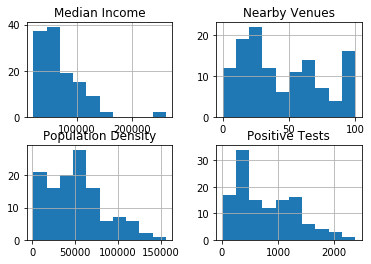

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

#plots histograms
histplots = df_fin[['Population Density','Median Income','Positive Tests','Nearby Venues']] 
histplots.hist()
plt.show()

#### Extracts columns to be used as features or independent variables

In [37]:
df_features = df_fin[['Population Density','Median Income','Nearby Venues']]
df_features.head()

,Population Density,Median Income,Nearby Venues
0,38085.0,88701.0,64
1,90078.0,37071.0,77
2,99889.0,104972.0,78
3,5515.0,128161.0,24
4,120158.0,135514.0,100


#### Extracts the number of positive tests column as the target or dependent variable

In [38]:
df_target = df_fin[['Positive Tests']]
df_target.head()

,Positive Tests
0,266
1,729
2,355
3,26
4,44


### Determines the correlation coefficient, p-value, R^2, and Mean-squared error (MSE) of each feature in respect to the target, and plots their relationship

#### Population Density

Correlation coefficient: -0.08645616539597073 and p_value: 0.34168719024233485


[Text(0, 0.5, 'Number of Positive Tests'),
 Text(0.5, 0, 'Population Density (people per sq mi)')]

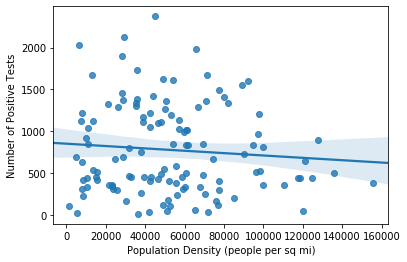

In [39]:
# correlation coefficient and p-value
coef, p_value = pearsonr(df_features['Population Density'].values, df_target.values.flatten())
print('Correlation coefficient: {} and p_value: {}' .format(coef,p_value))

# regression plot 
ax = sns.regplot(x="Population Density", y="Positive Tests", data=df_fin)
ax.set(xlabel='Population Density (people per sq mi)', ylabel='Number of Positive Tests')

In [40]:
# Simple Linear Regression 
lr = LinearRegression()
lr.fit(df_features[['Population Density']],df_target[['Positive Tests']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
# Calculates Yhat as the theoreotical value of Positive Tests based on Population Density 
Yhat = lr.predict(df_features[['Population Density']])

# Calculates MSE
mse = mean_squared_error(df_target[['Positive Tests']], Yhat)
print('The R-square is:', lr.score(df_features[['Population Density']],df_target[['Positive Tests']]))
print('The mean square error of price and predicted value is: ', mse)

The R-square is: 0.0074746685349754705
The mean square error of price and predicted value is:  279972.4324678927


#### Median Income

Correlation coefficient: -0.5424365434320946 and p_value: 9.142211008160841e-11


[Text(0, 0.5, 'Number of Positive Tests'),
 Text(0.5, 0, 'Median Household Income (USD)')]

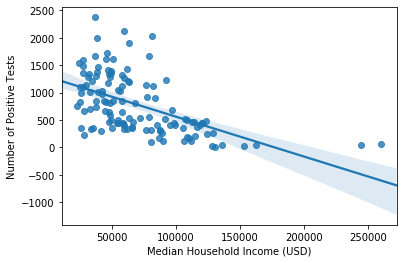

In [42]:
# correlation coefficient and p-value
coef, p_value = pearsonr(df_features['Median Income'].values, df_target.values.flatten())
print('Correlation coefficient: {} and p_value: {}' .format(coef,p_value))

# regression plot 
ax = sns.regplot(x="Median Income", y="Positive Tests", data=df_fin)
ax.set(xlabel='Median Household Income (USD)', ylabel='Number of Positive Tests')

In [43]:
# Simple Linear Regression
lr.fit(df_features[['Median Income']],df_target[['Positive Tests']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
# Calculates Yhat as the theoreotical value of Positive Tests based on Median Income 
Yhat = lr.predict(df_features[['Median Income']])

# Calculates MSE
mse = mean_squared_error(df_target[['Positive Tests']], Yhat)
print('The R-square is:', lr.score(df_features[['Median Income']],df_target[['Positive Tests']]))
print('The mean square error of price and predicted value is: ', mse)

The R-square is: 0.2942374036505587
The mean square error of price and predicted value is:  199082.1438815555


#### Number of nearby venues

Correlation coefficient: -0.4693375013133118 and p_value: 4.353257636464832e-08


[Text(0, 0.5, 'Number of Positive Tests'),
 Text(0.5, 0, 'Number of Nearby Venues')]

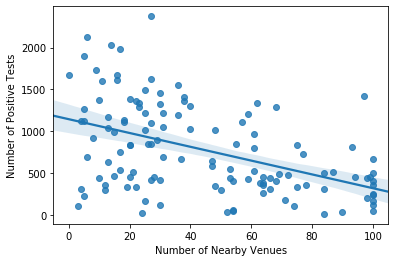

In [45]:
# correlation coefficient and p-value
coef, p_value = pearsonr(df_features['Nearby Venues'].values, df_target.values.flatten())
print('Correlation coefficient: {} and p_value: {}' .format(coef,p_value))

# Regression Plot 
ax = sns.regplot(x="Nearby Venues", y="Positive Tests", data=df_fin)
ax.set(xlabel='Number of Nearby Venues', ylabel='Number of Positive Tests')

In [46]:
# Simple Linear Regression 
lr.fit(df_features[['Nearby Venues']],df_target[['Positive Tests']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
# Calculates Yhat as the theoreotical value of Positive Tests based on number of nearby venues
Yhat = lr.predict(df_features[['Nearby Venues']])

# Calculates MSE
mse = mean_squared_error(df_target[['Positive Tests']], Yhat)
print('The R-square is:', lr.score(df_features[['Nearby Venues']],df_target[['Positive Tests']]))
print('The mean square error of price and predicted value is: ', mse)

The R-square is: 0.2202776901390231
The mean square error of price and predicted value is:  219944.76596283665


### Performs Multiple Linear Regression to test if Positive Tests correlate to a combination of the features 
#### Population Density does not seem to correlate to Positive Covid19 Tests, so it will be dropped from the feature list 

In [48]:
df_features.drop('Population Density', axis = 1, inplace = True)
df_features.head()

C:\Users\sonle\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Median Income,Nearby Venues
0,88701.0,64
1,37071.0,77
2,104972.0,78
3,128161.0,24
4,135514.0,100


#### Preprocessing 

In [49]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_features)
X = scaler.transform(df_features)
X[0:10]

array([[ 0.48046334,  0.64578559],
       [-0.82055756,  1.07532435],
       [ 0.89047517,  1.10836579],
       [ 1.47481322, -0.67587211],
       [ 1.66010097,  1.83527753],
       [ 1.53539145,  1.30661445],
       [ 4.41159762,  1.5048631 ],
       [-0.15936276,  0.54666127],
       [ 1.13588757,  1.76919464],
       [ 1.24066474,  0.31537117]])

#### Builds multiple linear regression model

In [50]:
lr.fit(X, df_target[['Positive Tests']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Evaluates the model

In [51]:
# Calculates Yhat as the theoreotical value of Positive Tests based on Median Income and the number of nearby venues
Yhat = lr.predict(X)

#Calculates MSE 
mse = mean_squared_error(df_target[['Positive Tests']], Yhat)
print('The correlation coefficients are: ', lr.coef_[0][0],'and ', lr.coef_[0][1])
print('The R-square is:', lr.score(X,df_target[['Positive Tests']]))
print('The mean square error of price and predicted value is: ', mse)

The correlation coefficients are:  -224.05639921794537 and  -159.0705432167647
The R-square is: 0.3694019794730984
The mean square error of price and predicted value is:  177879.6531628636


#### Visualizes the accuracy of the model

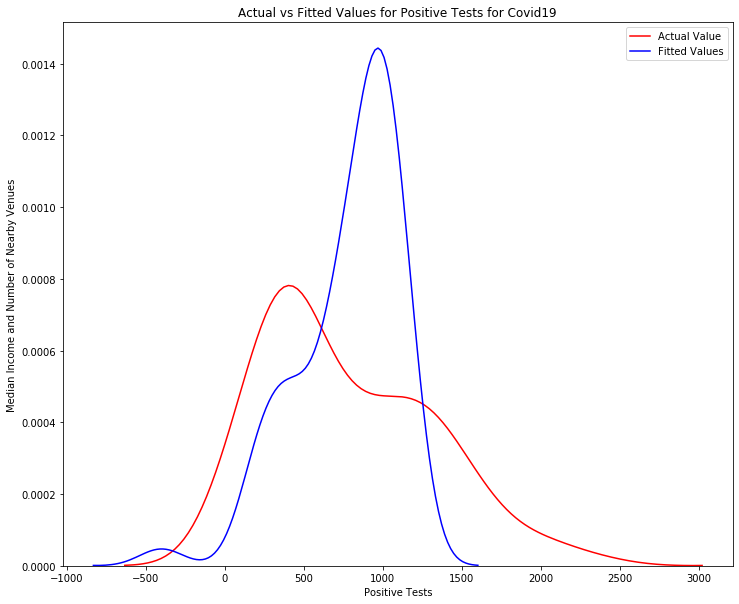

In [52]:
plt.figure(figsize=(12,10))


ax1 = sns.distplot(df_target['Positive Tests'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Positive Tests for Covid19')
plt.xlabel('Positive Tests')
plt.ylabel('Median Income and Number of Nearby Venues')

plt.show()
plt.close()

### Explores the actual venues and the relationship between venue category and Positive Covid19 Tests using KMeans Clustering

#### Performs one hot encoding to analyze each zip code's venues

In [53]:
nyc_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

nyc_onehot['Zip Code'] = venues['Zip Code'] 


fixed_columns = [nyc_onehot.columns[-1]] + nyc_onehot.columns[:-1].values.tolist()
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Zip Code,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Finds the mean of frequency of occurence of venues in each zip code

In [54]:
nyc_gb = nyc_onehot.groupby('Zip Code').mean().reset_index()
nyc_gb.head()

,Zip Code,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.015625,0.0,...,0.0,0.0,0.0,0.015625,0.015625,0.015625,0.0,0.0,0.046875,0.0
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.025974,0.038961,0.0,0.0,0.012987,0.0
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.025641,0.0,0.0,0.012821,0.0
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


#### Determines the most popular venues in each zip code 

In [55]:
# function that returns the most common value
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create columns according to number of top venues 
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zip Code'] = nyc_gb['Zip Code']

for ind in np.arange(nyc_gb.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_gb.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10001,Bar,Cocktail Bar,Yoga Studio,Boutique,Coffee Shop,Tea Room,Café,Scenic Lookout,Art Gallery,French Restaurant
1,10002,Italian Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Wine Shop,Cocktail Bar,Grocery Store,Café,Asian Restaurant,Rock Club
2,10003,Grocery Store,Ice Cream Shop,Café,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Chinese Restaurant,Juice Bar,Speakeasy
3,10004,Boat or Ferry,Cocktail Bar,Park,Mexican Restaurant,Heliport,Japanese Restaurant,History Museum,Museum,Snack Place,Pedestrian Plaza
4,10005,Coffee Shop,Gym / Fitness Center,American Restaurant,Cocktail Bar,Gym,Hotel,Falafel Restaurant,Mexican Restaurant,Park,Jewelry Store


#### Creates a list of a range of available KMeans clusters vs their Silhoutte scores

In [56]:
nyc_gb_clustering = nyc_gb.drop('Zip Code', 1)
max_range = 20

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    nyc_cluster = nyc_gb_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(nyc_cluster)
    
    score = silhouette_score(nyc_cluster, kmeans)
    
    indices.append(kclusters)
    scores.append(score)

#### Plots number of KMeans cluster vs Silhoutte scores

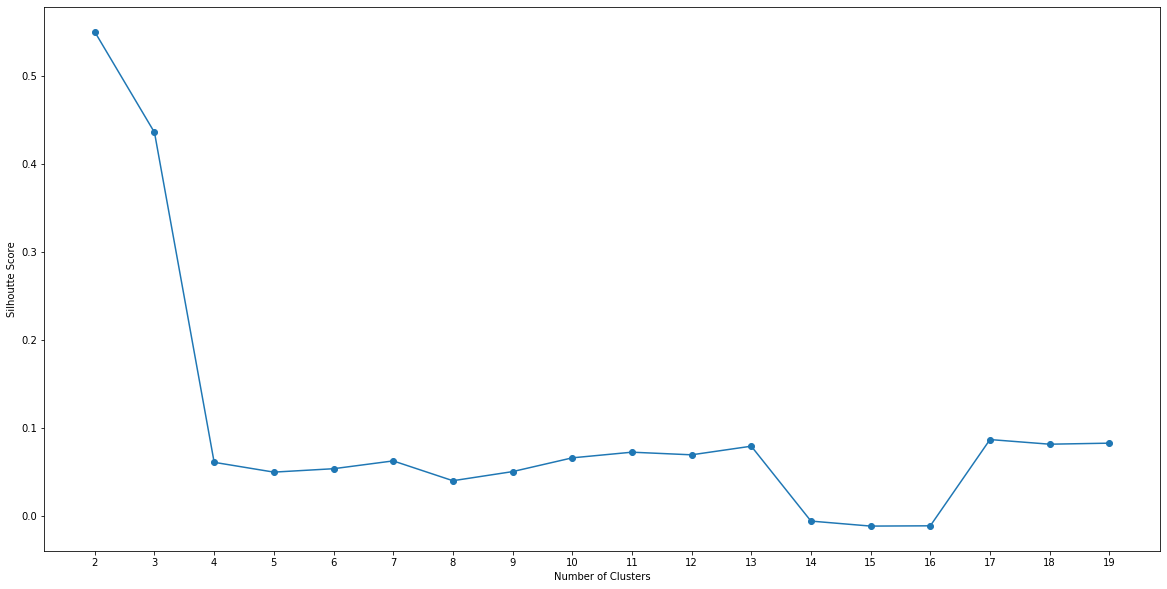

In [57]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_range), scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.xticks(np.arange(2, max_range))
plt.show()

#### Returns the most optimal number of KMeans cluster

In [58]:
opt = np.argmax(scores) + 2 
opt

2

#### Runs KMeans Machine Learning algortithm

In [59]:
kclusters = opt

nyc_cluster = nyc_gb_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(nyc_cluster)

#### Inserts Clustering Labels 

In [60]:
zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
zipcodes_venues_sorted.head()

,Cluster Labels,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,10001,Bar,Cocktail Bar,Yoga Studio,Boutique,Coffee Shop,Tea Room,Café,Scenic Lookout,Art Gallery,French Restaurant
1,0,10002,Italian Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Wine Shop,Cocktail Bar,Grocery Store,Café,Asian Restaurant,Rock Club
2,0,10003,Grocery Store,Ice Cream Shop,Café,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Chinese Restaurant,Juice Bar,Speakeasy
3,0,10004,Boat or Ferry,Cocktail Bar,Park,Mexican Restaurant,Heliport,Japanese Restaurant,History Museum,Museum,Snack Place,Pedestrian Plaza
4,0,10005,Coffee Shop,Gym / Fitness Center,American Restaurant,Cocktail Bar,Gym,Hotel,Falafel Restaurant,Mexican Restaurant,Park,Jewelry Store


#### Creates a compiled dataframe from zipcodes_venues_sorted with each zip code's coordinates

In [61]:
df_location = df_fin[['Zip Code','Latitude','Longitude']]

In [62]:
nyc_cluster_df = df_location
nyc_cluster_df = nyc_cluster_df.join(zipcodes_venues_sorted.set_index('Zip Code'), on='Zip Code')
nyc_cluster_df.dropna(inplace = True)
nyc_cluster_df['Cluster Labels'] = nyc_cluster_df['Cluster Labels'].astype(int)
nyc_cluster_df.head()

,Zip Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10001,40.729825,-73.960752,0,Bar,Cocktail Bar,Yoga Studio,Boutique,Coffee Shop,Tea Room,Café,Scenic Lookout,Art Gallery,French Restaurant
1,10002,40.722313,-73.987709,0,Italian Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Wine Shop,Cocktail Bar,Grocery Store,Café,Asian Restaurant,Rock Club
2,10003,40.731609,-73.988484,0,Grocery Store,Ice Cream Shop,Café,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Chinese Restaurant,Juice Bar,Speakeasy
3,10004,40.700732,-74.013475,0,Boat or Ferry,Cocktail Bar,Park,Mexican Restaurant,Heliport,Japanese Restaurant,History Museum,Museum,Snack Place,Pedestrian Plaza
4,10005,40.705636,-74.008900,0,Coffee Shop,Gym / Fitness Center,American Restaurant,Cocktail Bar,Gym,Hotel,Falafel Restaurant,Mexican Restaurant,Park,Jewelry Store


### Visualizes the clustering of zipcodes

In [63]:
map_clusters = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_cluster_df['Latitude'], nyc_cluster_df['Longitude'], nyc_cluster_df['Zip Code'], nyc_cluster_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

#### Creates a DataFrame of outliers (entries of clusters label < 2) according to the map above

In [64]:
to_explore = zipcodes_venues_sorted[zipcodes_venues_sorted['Cluster Labels'] > 0]
to_explore

,Cluster Labels,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,1,10305,Bus Stop,Hotel,Coffee Shop,Athletics & Sports,Zoo,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Merges with df_fin to create a grand dataframe

In [65]:
df_explore = pd.merge(left=to_explore, right=df_fin, left_on='Zip Code', right_on='Zip Code')
df_explore

,Cluster Labels,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,Population Density,Median Income,Positive Tests,Total Tests,Percentage of Total,Nearby Venues
0,1,10305,Bus Stop,Hotel,Coffee Shop,Athletics & Sports,Zoo,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,40.609109,-74.07608,9908.0,77135.0,914,2128,42.95,8


#### Removes the 6th - 10th Most Common Venue, Latitude, and Longitude columns for better visibility

In [66]:
drop_venues = ['6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue','Latitude','Longitude']
df_explore.drop(drop_venues, axis = 1, inplace = True)
df_explore

,Cluster Labels,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Population Density,Median Income,Positive Tests,Total Tests,Percentage of Total,Nearby Venues
0,1,10305,Bus Stop,Hotel,Coffee Shop,Athletics & Sports,Zoo,9908.0,77135.0,914,2128,42.95,8


#### Calculates the zip codes' average number of positive tests and average percentage of positive tests

In [67]:
average_positive_tests = df_fin[['Positive Tests']].values.mean()
print('The average number of positive tests is: {}'.format(round(average_positive_tests)))
average_percentage = df_fin[['Percentage of Total']].values.mean()
print('The average percentage of positive tests is: {}' .format(round(average_percentage,2)))
average_venues = df_fin[['Nearby Venues']].values.mean()
print('The average number of venues in the zip codes is: {}' .format(round(average_venues)))

The average number of positive tests is: 778.0
The average percentage of positive tests is: 50.11
The average number of venues in the zip codes is: 44.0


#### Calculates the outlier zip codes' average number of positive tests and average percentage of positive tests

In [68]:
average_positive_tests_outlier = df_explore[['Positive Tests']].values.mean()
print('The average number of positive tests for outlier zip codes is: {}'.format(round(average_positive_tests_outlier)))
average_percentage_outlier = df_explore[['Percentage of Total']].values.mean()
print('The average percentage of positive tests for outlier zip codes is: {}' .format(round(average_percentage_outlier,2)))
average_venues_outlier = df_explore[['Nearby Venues']].values.mean()
print('The average number of venues in the zip codes for outlier zip codes is: {}' .format(round(average_venues_outlier)))

The average number of positive tests for outlier zip codes is: 914.0
The average percentage of positive tests for outlier zip codes is: 42.95
The average number of venues in the zip codes for outlier zip codes is: 8.0
